In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from qiskit.visualization import plot_histogram

## Quantum Key Distribution
Alice wants to send a private message to Bob. But first they have to establish a shared secret key! (This exercise is an adpated version of a [qiskit tutorial](https://github.com/qmunitytech/Tutorials/blob/main/intermediate/The%20BB84%20Quantum%20Cryptography%20algorithm.ipynb).)


##### Step 0: Prepare bit strings for measurements and states

In [16]:
num_qubits = 10

alice_basis = np.random.randint(2, size=num_qubits)
alice_state = np.random.randint(2, size=num_qubits)
bob_basis = np.random.randint(2, size=num_qubits)
eve_basis = np.random.randint(2, size=num_qubits)
#eve_basis = None


print(f"Alice's State:\t {np.array2string(alice_state)}")
print(f"Alice's Bases:\t {np.array2string(alice_basis)}")
print(f"Bob's Bases:\t {np.array2string(bob_basis)}")
if eve_basis is not None:
    print(f"Eve's Bases:\t {np.array2string(eve_basis)}")

Alice's State:	 [1 1 1 0 1 0 0 1 1 1]
Alice's Bases:	 [1 0 0 1 1 0 1 1 0 0]
Bob's Bases:	 [0 1 0 1 0 1 1 1 1 0]
Eve's Bases:	 [0 0 0 0 1 1 1 0 1 0]


NOTE: When Alice's state bit is 1 (0) and her basis bit is **0**, this means that she is using the computational basis (Z basis) to encode the state |1⟩ (|0⟩). However, if Alice's state is 1 (0) and her basis is **1**, that means she is using the hadamard gate (X basis) to encode the state 1 (0)  which will result in |-⟩ (|+⟩).

##### Step 1: Construct the BB84 circuit

In [17]:
def bb84_circuit(state, basis, measurement_basis):
   
    #state: array of 0s and 1s denoting the state to be encoded
    #basis: array of 0s and 1s denoting the basis to be used for encoding
                #0 -> Computational Basis
                #1 -> Hadamard Basis
    #meas_basis: array of 0s and 1s denoting the basis to be used for measurement
                #0 -> Computational Basis
                #1 -> Hadamard Basis
    
    num_qubits = len(state)
    
    circuit = QuantumCircuit(num_qubits)
    
    # Sender prepares qubits
    for i in range(len(basis)):
    # Prepare the circuit according to selection of state and basis
    # Your code goes here:
        if state[i]:
            circuit.x(i)
        if basis[i]:
            circuit.h(i)


    # Measuring action performed by reciever
    for i in range(len(measurement_basis)):
    # Prepare the circuit according to the measurement basis
    # Your code goes here:
        if measurement_basis[i] == 1:
            circuit.h(i)
              
    circuit.measure_all()
    
    return circuit

##### Step 2: Run the circuit on Aer simulator

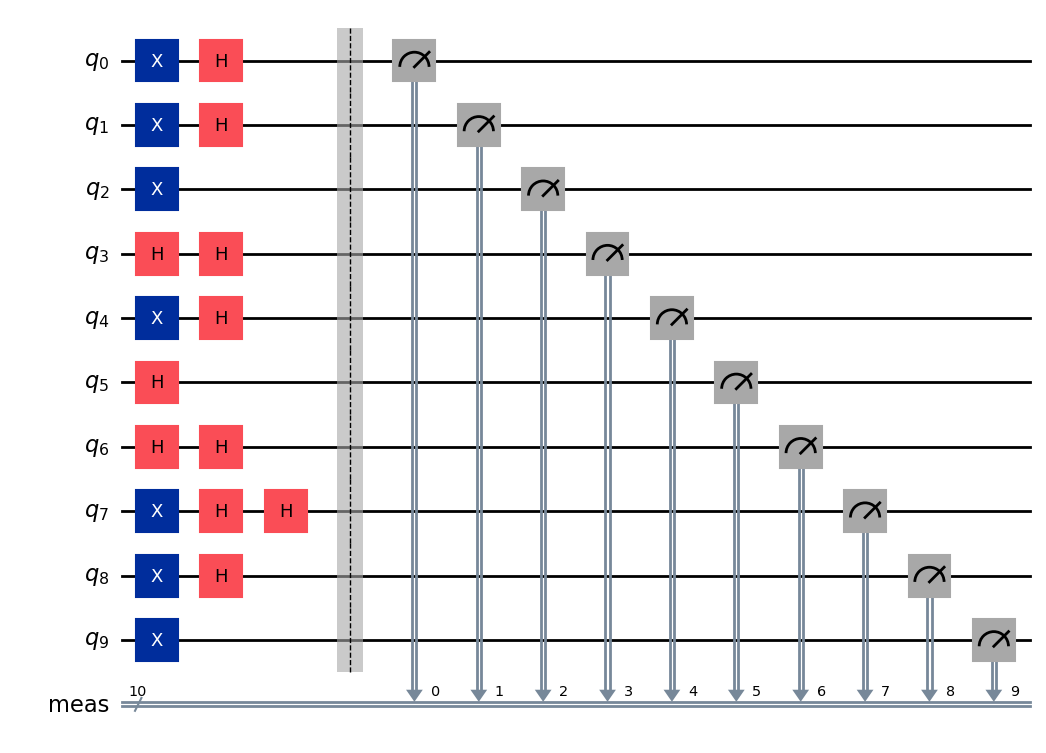

In [18]:
circuit = bb84_circuit(alice_state, alice_basis, bob_basis)
circuit.draw("mpl")

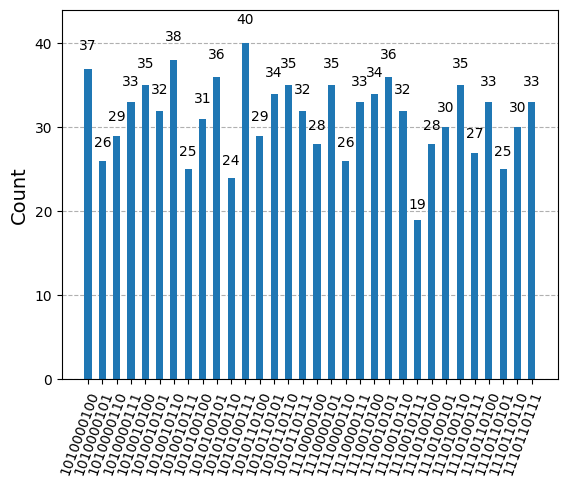

In [19]:
backend = Aer.get_backend('aer_simulator', seed_simulator=42)
mapped_circuit = transpile(circuit, backend, seed_transpiler=42)

job = backend.run(mapped_circuit,shots=1000)
result = job.result()
bob_counts = result.get_counts(mapped_circuit).most_frequent()
plot_histogram(result.get_counts())

##### Step 3: Retrieve the key (measurement basis match)

In [20]:

def validation(alice_state,alice_basis,bob_state,bob_basis,):
    
    key = ''
    for i in range(num_qubits):
        if alice_basis[i] == bob_basis[i]:
            if alice_state[i] == bob_state[i]:
                key += str(alice_state[i])
            else:
                print(f'Message has been intercepted.\nQubit {i} with identical encryption/decryption basis ({alice_basis[i]}/{bob_basis[i]}) yields unidentical state.')
                print(f'Alice basis: {alice_basis[i]}\t Alice state: {alice_state[i]}')
                print(f'Bob   basis: {bob_basis[i]}\t Bob   state: {bob_state[i]}')
                return key
    print(f'Message delivered safely.')
    print(f'Key: {key}')
    return key
   


In [21]:
bob_state = [int(i) for i in reversed(bob_counts)]
validation(alice_state,alice_basis,bob_state,bob_basis)  

Message delivered safely.
Key: 10011


'10011'

### Chance of getting away with Eavesdrop

Now let's include Eve in the communication loop.

Eve intercepts the message by measuring the qubits in her own random measurement basis.

How likely is it that the eavesdropping will be noticed?

* 1/2 chance of guessing the right basis (0,1)
* 1/2 chance of getting the right result with wrong basis

There is a 25% chance that she would measure a wrong value for every bit $n \in N$

The probability to detect the eavesdropping is $1-\left( \frac{3}{4} \right)^n$

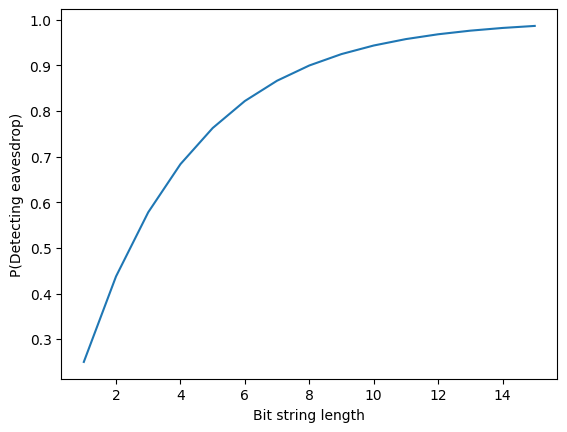

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,16),1-0.75**np.arange(1,16))
plt.xlabel('Bit string length')
plt.ylabel('P(Detecting eavesdrop)')
plt.show()

### implement circuit with Eve

In [23]:
circuit_eve = bb84_circuit(alice_state, alice_basis, eve_basis)
mapped_circuit_eve = transpile(circuit_eve, backend, seed_transpiler=42)
eve_counts = backend.run(mapped_circuit_eve,shots=1).result().get_counts().most_frequent()
eve_state = [int(i) for i in reversed(eve_counts)]

In [24]:
circuit_bob = bb84_circuit(eve_state, eve_basis, bob_basis)
mapped_circuit_bob = transpile(circuit_bob, backend, seed_transpiler=42)
bob_counts = backend.run(mapped_circuit_bob,shots=1).result().get_counts().most_frequent()
bob_state = [int(i) for i in reversed(bob_counts)]

In [25]:
validation(alice_state,alice_basis,bob_state,bob_basis)  

Message has been intercepted.
Qubit 7 with identical encryption/decryption basis (1/1) yields unidentical state.
Alice basis: 1	 Alice state: 1
Bob   basis: 1	 Bob   state: 0


'100'